In [1]:
# Libraries

import numpy
import os
import shutil

In [2]:
# Code

from src.data.feature import annodata as data_anndata
from src.data.feature import target   as data_target
from src.io           import loader   as data_loader
from src.io           import writer   as data_writer

# 1. Setup

In [3]:
# Setup some directory paths

OUT_SUBFOLDER = 'nbp05-target'
RES_SUBFOLDER = ''

CWD = os.getcwd()
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_DATA  = os.path.join(OUT, 'data',  OUT_SUBFOLDER)
OUT_PLOT  = os.path.join(OUT, 'plot',  OUT_SUBFOLDER)
RES_PLANT = os.path.join(RES, 'plant', RES_SUBFOLDER)
RES_NBP02 = os.path.join(OUT, 'data',  'nbp02-anndata')

shutil.rmtree(OUT_DATA, ignore_errors = True)
shutil.rmtree(OUT_PLOT, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res


In [4]:
# Load the annotated and cleaned data

anndata = data_loader.load_h5ad(
	filename = os.path.join(RES_NBP02, 'arabidopsis-r36.h5ad')
)

# 2. TPM Regression

In [5]:
# Extract the gene tpm values per group

tpm_value, group_order = data_target.extract_tpm_value(
	data      = anndata,
	layer     = 'normal',
	groups    = ['Tissue', 'Age', 'Group', 'Perturbation'] ,
	functions = [
		numpy.mean,
		numpy.std,
		numpy.max
	]
)

  0%|          | 0/34517 [00:00<?, ?it/s]

In [6]:
# Display an example of the gene tpm values

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(tpm_value[gene].items()) :
	print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:5.2f}'.format(x) for x in value))

tissue-mean       : [ 8]  0.34  0.29  0.26  0.46  0.33  0.37  0.32  0.10
tissue-std        : [ 8]  0.05  0.10  0.13  0.07  0.07  0.08  0.18  0.08
tissue-amax       : [ 8]  0.47  0.57  0.46  0.60  0.55  0.58  0.55  0.24
age-mean          : [ 5]  0.33  0.36  0.32  0.24  0.40
age-std           : [ 5]  0.10  0.08  0.04  0.18  0.08
age-amax          : [ 5]  0.58  0.57  0.40  0.55  0.60
group-mean        : [19]  0.35  0.28  0.26  0.46  0.29  0.36  0.32  0.38  0.37  0.30  0.32  0.32  0.10  0.37  0.36  0.27  0.46  0.41  0.38
group-std         : [19]  0.05  0.10  0.13  0.08  0.06  0.07  0.02  0.09  0.08  0.06  0.04  0.18  0.08  0.01  0.03  0.00  0.06  0.08  0.08
group-amax        : [19]  0.47  0.56  0.46  0.58  0.35  0.58  0.36  0.57  0.47  0.38  0.40  0.55  0.24  0.38  0.43  0.28  0.60  0.55  0.58
perturbation-mean : [ 8]  0.40  0.34  0.43  0.35  0.31  0.31  0.23  0.33
perturbation-std  : [ 8]  0.08  0.10  0.05  0.09  0.10  0.11  0.19  0.11
perturbation-amax : [ 8]  0.60  0.58  0.52  0.58  0.5

In [7]:
# Compute the classification distribution

distribution = data_target.distribution_group(
	data   = tpm_value,
	order  = group_order,
	select = 'mean',
	genes  = anndata.var.index.to_list()
)

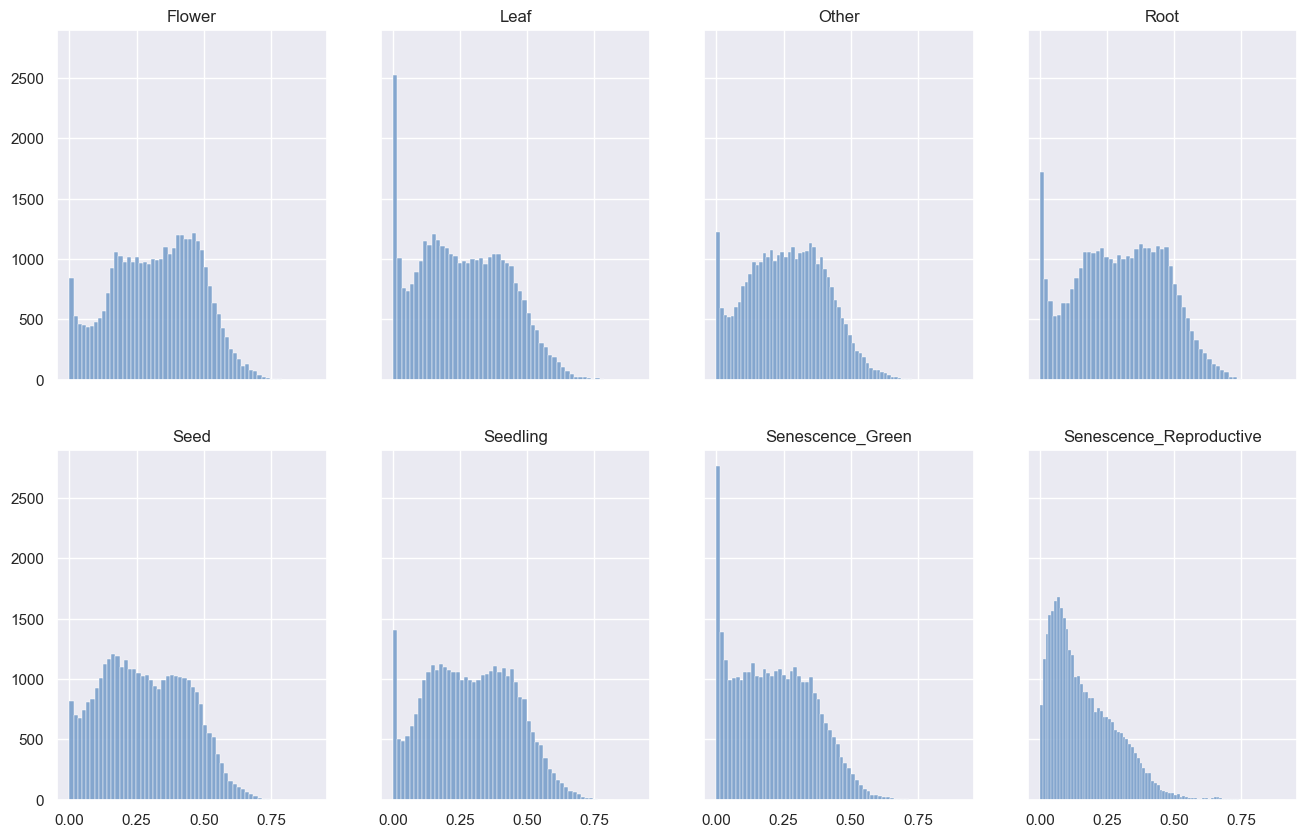

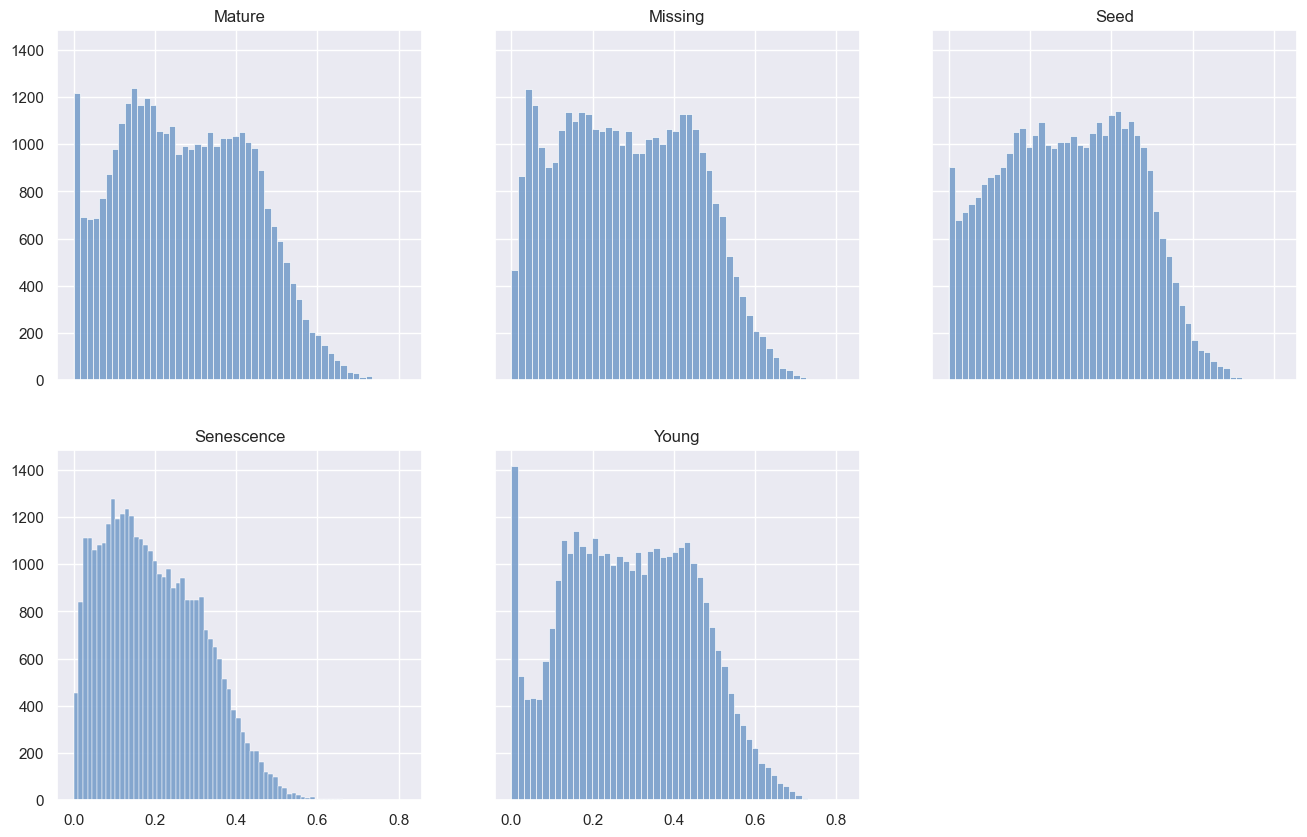

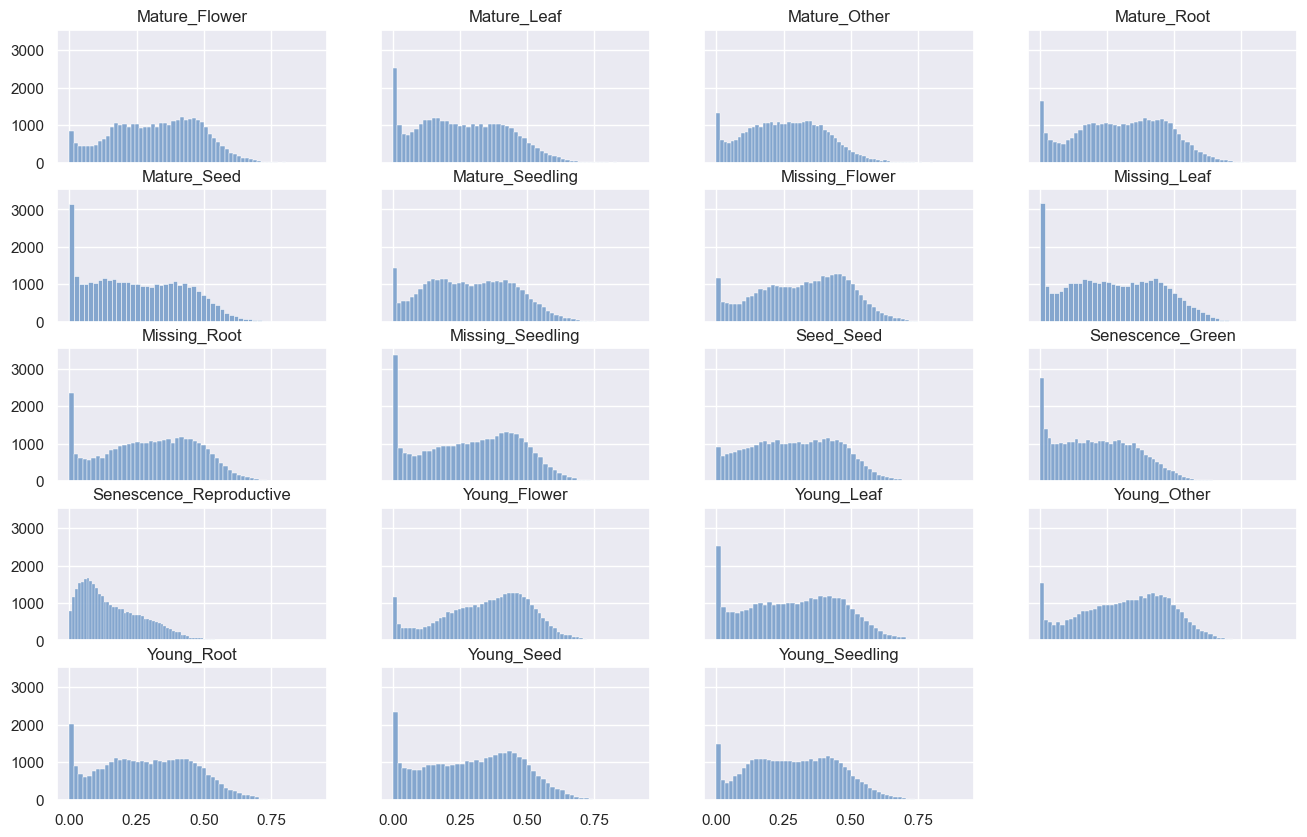

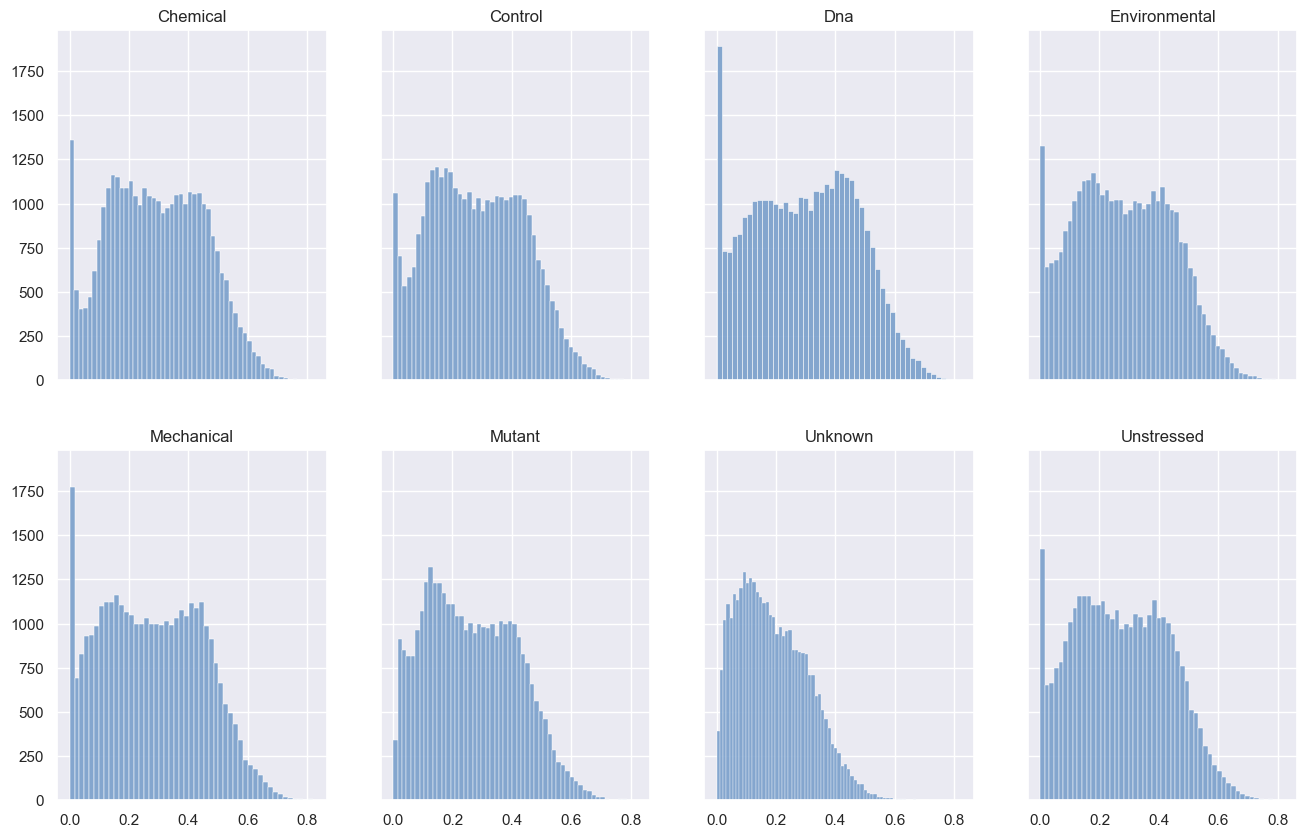

In [8]:
# Display the gene classification distribution per group and type

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-tpm-tissue')
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'age',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-tpm-age')
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'group',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-tpm-group')
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'perturbation',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-tpm-perturbation')
)

In [9]:
# Save the target gene tpm values

data_writer.write_json(
	data     = tpm_value,
	filename = os.path.join(OUT_DATA, 'target-tpm-value.json')
)

data_writer.write_json(
	data     = group_order,
	filename = os.path.join(OUT_DATA, 'target-tpm-order.json')
)

# 3 TPM Classification

In [10]:
#
import numpy

matrix = numpy.array([
	numpy.array(v['tissue-mean'])
	for v in tpm_value.values()
]).flatten()

groups = 5
bounds = list()
margin = 100 / groups

for index in range(groups) :
	source = margin * index
	target = margin + source

	print(f'Category {index} [{source:4.1f} % <==> {target:5.1f} %] : ', end = '')

	source = numpy.percentile(matrix, source)
	target = numpy.percentile(matrix, target)

	print(f'{source:.5f} - {target:.5f}')

	bounds.append((
		f'Category {index}',
		source
	))

Category 0 [ 0.0 % <==>  20.0 %] : 0.00000 - 0.10479
Category 1 [20.0 % <==>  40.0 %] : 0.10479 - 0.20321
Category 2 [40.0 % <==>  60.0 %] : 0.20321 - 0.30543
Category 3 [60.0 % <==>  80.0 %] : 0.30543 - 0.41509
Category 4 [80.0 % <==> 100.0 %] : 0.41509 - 0.91222


In [11]:
minval = numpy.min(anndata.layers['log1p'])
maxval = numpy.max(anndata.layers['log1p'])

print(f'Min value : {minval: 8.4f}')
print(f'Max value : {maxval: 8.4f}')

def log2tpm  (x) : return numpy.exp2(x) - 1
def tpm2log  (x) : return numpy.log2(x + 1)
def log2norm (x) : return (x - minval) / maxval
def norm2log (x) : return (x * maxval) + minval

bounds_norm = bounds
bounds_log  = [(name, norm2log(x = x)) for name, x in bounds_norm]
bounds_tpm  = [(name, log2tpm(x = x))  for name, x in bounds_log]

Min value :   0.0000
Max value :  19.3022


In [12]:
# Display the classification tpm bounds

print('                TPM |        log1p |         norm')
print('--------------------+--------------+-------------')

for x, y, z in zip(bounds_tpm, bounds_log, bounds_norm) :
	print(f'{x[0]} : {x[1]:6.1f} |  {y[1]:11.8f} |  {z[1]:11.8f}')

                TPM |        log1p |         norm
--------------------+--------------+-------------
Category 0 :    0.0 |   0.00000000 |   0.00000000
Category 1 :    3.1 |   2.02276174 |   0.10479435
Category 2 :   14.2 |   3.92242228 |   0.20321112
Category 3 :   58.5 |   5.89541577 |   0.30542710
Category 4 :  257.2 |   8.01211311 |   0.41508802


In [13]:
# Extract the gene tpm classification per group (reuses tpm values from regression extraction)

tpm_level = data_target.extract_tpm_level(
	data   = tpm_value,
	bounds = bounds_norm
)

  0%|          | 0/34517 [00:00<?, ?it/s]

In [14]:
# Display an example of the gene classification

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(tpm_level[gene].items()) :
	if isinstance(value[0], str) :
		print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:7s}'.format(x) for x in value))
	else :
		print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:1d}'.format(x) for x in value))

tissue-mean       : [ 8] 3 2 2 4 3 3 3 0
tissue-std        : [ 8] 0 0 1 0 0 0 1 0
tissue-amax       : [ 8] 4 4 4 4 4 4 4 2
age-mean          : [ 5] 3 3 3 2 3
age-std           : [ 5] 0 0 0 1 0
age-amax          : [ 5] 4 4 3 4 4
group-mean        : [19] 3 2 2 4 2 3 3 3 3 2 3 3 0 3 3 2 4 3 3
group-std         : [19] 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
group-amax        : [19] 4 4 4 4 3 4 3 4 4 3 3 4 2 3 4 2 4 4 4
perturbation-mean : [ 8] 3 3 4 3 3 3 2 3
perturbation-std  : [ 8] 0 0 0 0 0 1 1 1
perturbation-amax : [ 8] 4 4 4 4 4 4 4 4


In [15]:
# Compute the classification distribution

distribution = data_target.distribution_group(
	data   = tpm_level,
	order  = group_order,
	select = 'mean',
	genes  = anndata.var.index.to_list()
)

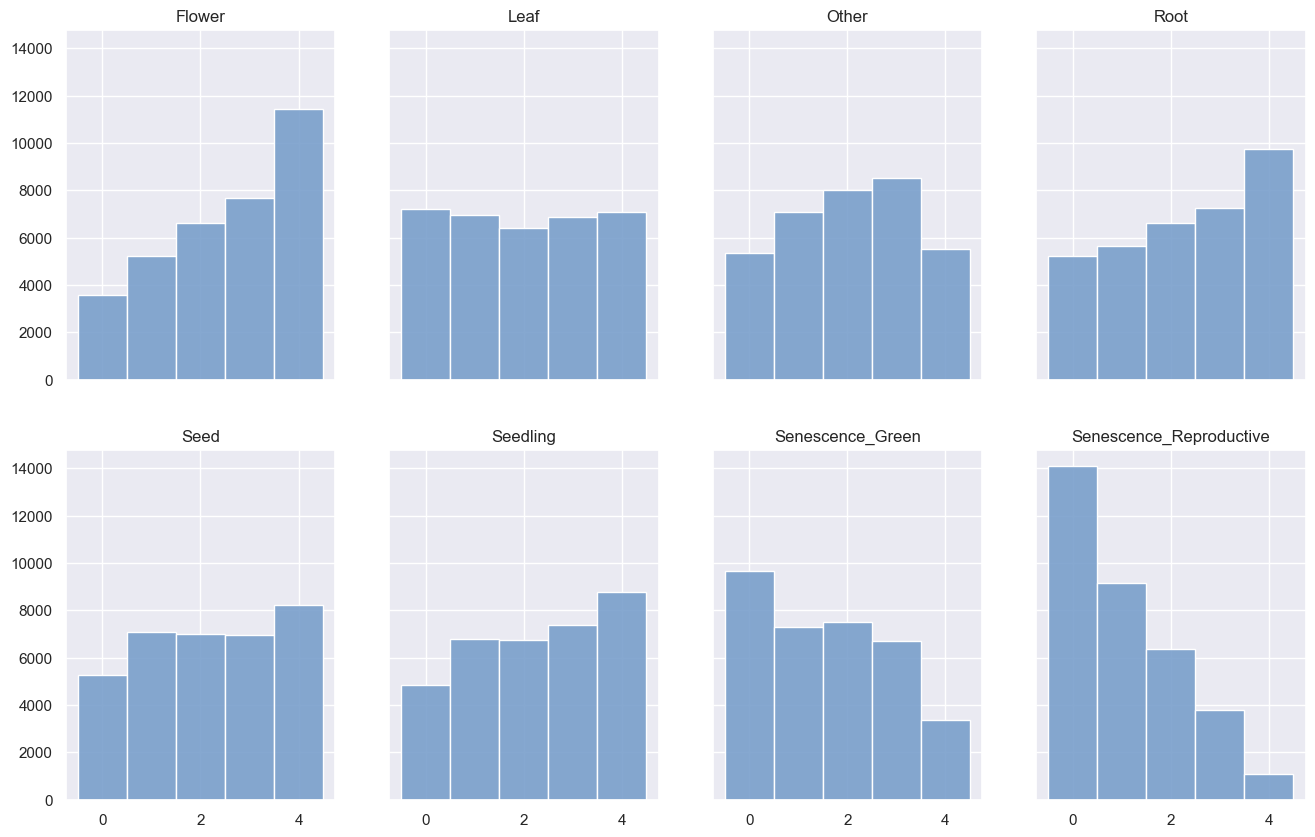

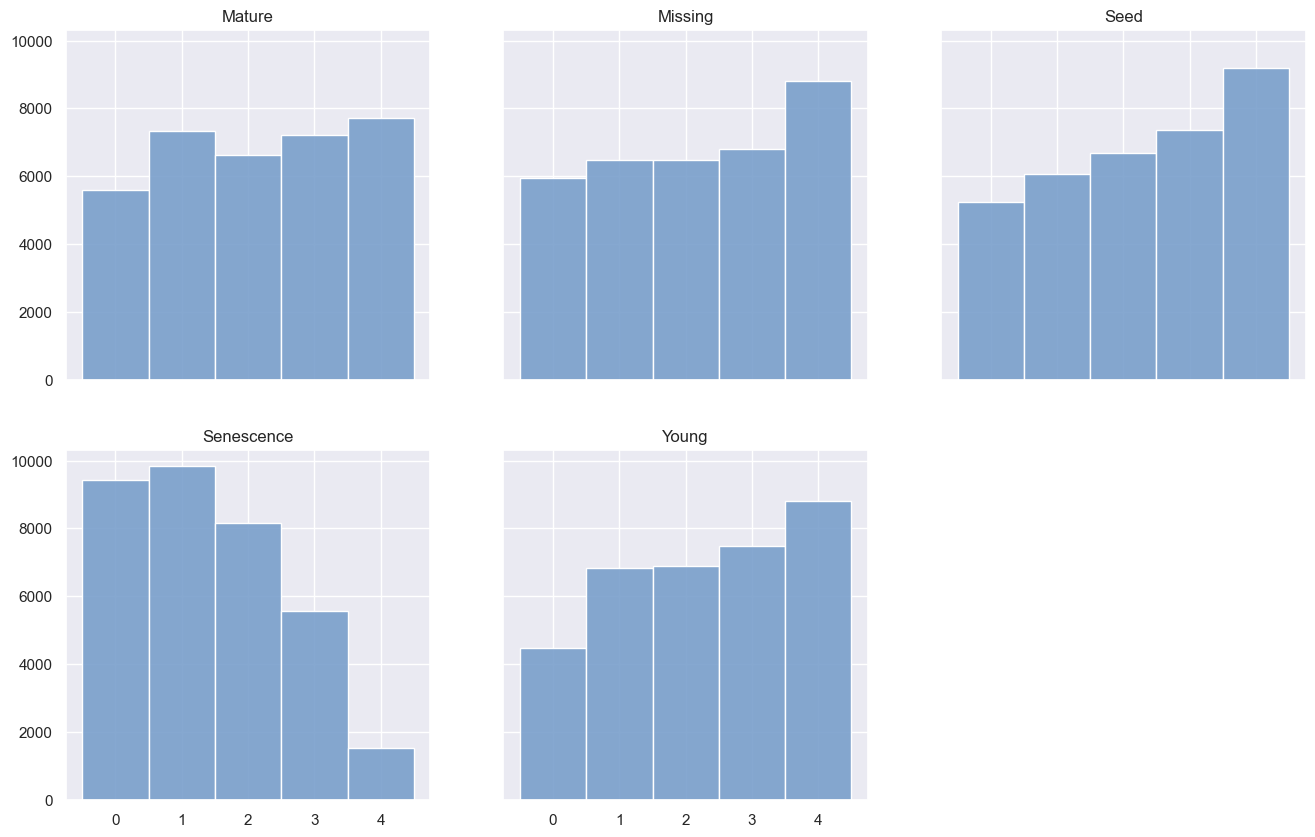

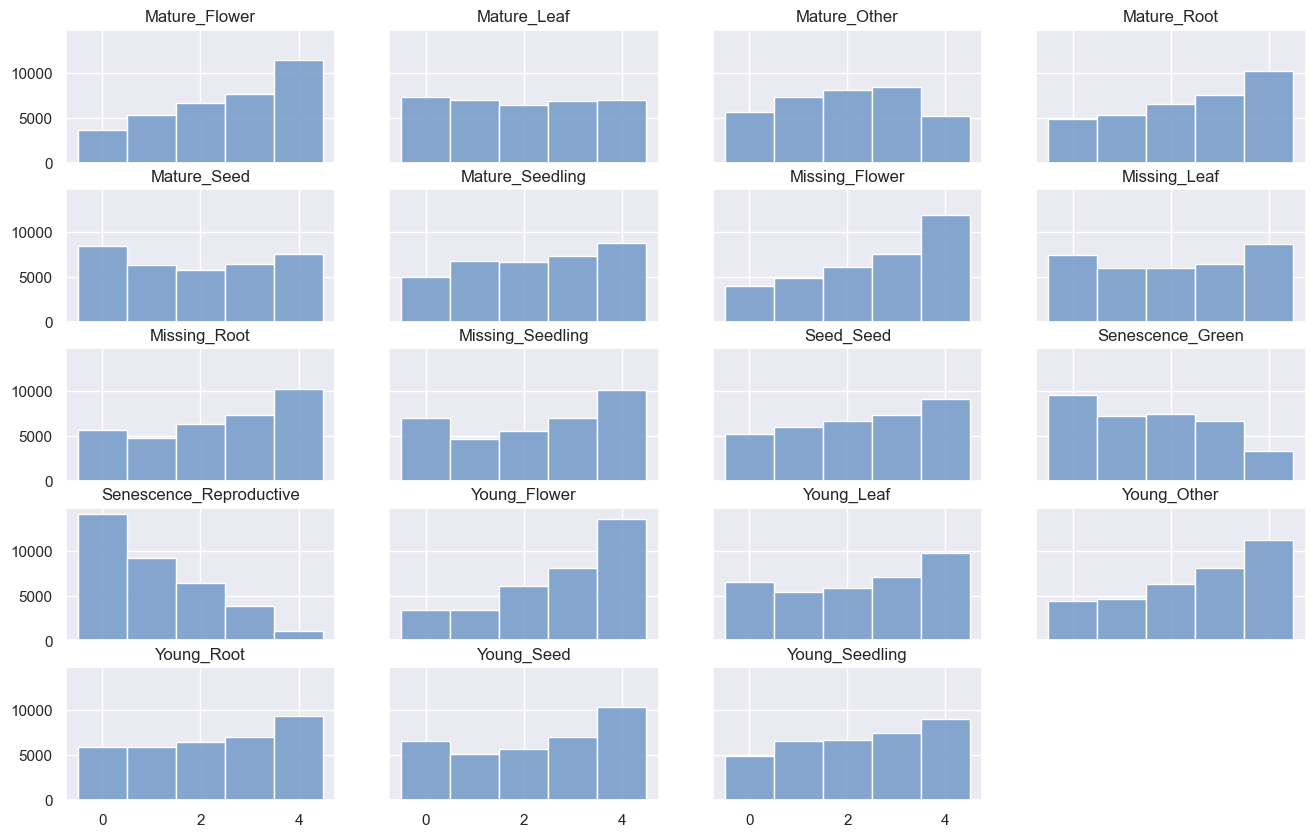

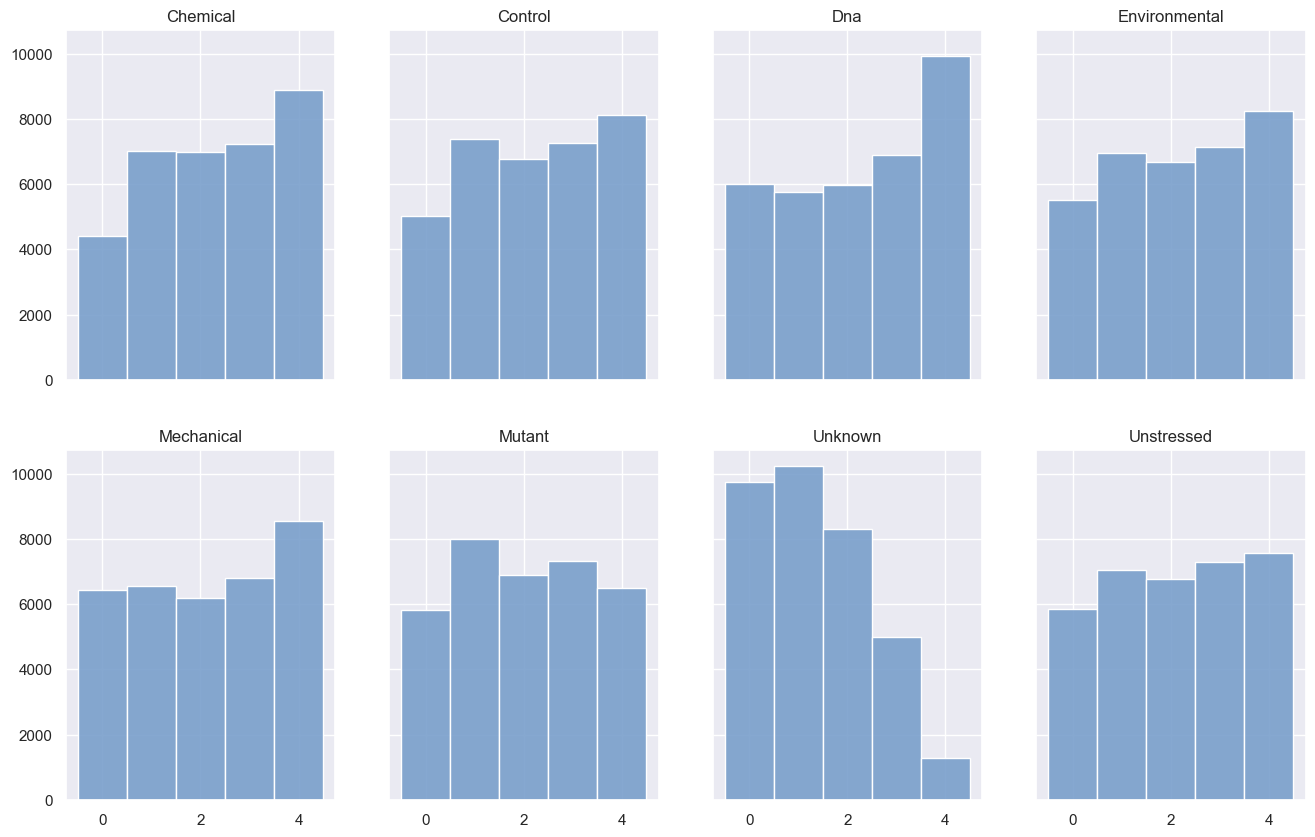

In [16]:
# Display the gene classification distribution per group and type

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-cls-tissue')
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'age',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-cls-age')
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'group',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-cls-group')
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'perturbation',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-cls-perturbation')
)

In [17]:
# Save the target gene classification

data_writer.write_json(
	data     = tpm_level,
	filename = os.path.join(OUT_DATA, 'target-tpm-level.json')
)